In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys

import py4DSTEM

## Defining helper functions

In [2]:
# Load original Nion Swift data files or py4DSTEM .h5 files.
def load_data(data_path):

    import copy
    from pathlib import Path

    from py4DSTEM.io import (
        save,
        read
    )
    
    import json
    import h5py

    filetype = str(os.path.splitext(data_path)[1])
    
    if filetype == '.ndata1' or filetype == '.ndata':
        data = np.load(data_path)
        metadata = json.loads(data['metadata.json'])

        return data['data'], metadata
    
    elif filetype == '.h5':
        try:
            data = read(data_path, data_id=0)
            return data, None
        except:
            file = h5py.File(data_path, 'r')
            data = file['data'][:]
            metadata = json.loads(file['data'].attrs['properties'])
            file.close()
            return data, metadata
        
    elif filetype =='.dm3' or filetype =='.dm4':
        vacuum_probe = ncemio.read(data_path)["data"]
        
        return data, None

In [3]:
# Load metadata from a file without loading the data.
def load_metadata(data_path, filetype):
    import json
    
    if filetype == '.ndata':
        data = np.load(data_path)
        metadata = json.loads(data['metadata.json'])
        
        return metadata, data['data'].shape

    elif filetype == '.h5':
        import h5py
        file = h5py.File(data_path, 'r')
        shape = file['data'].shape
        metadata = json.loads(file['data'].attrs['properties'])
        file.close()
        
        return metadata, shape

In [4]:
# Print metadata from a file without loading the data.
# fov = field of view in Å; rpx = scan size in scan size in pixels; qpix = diffraction pattern size in pixels.
def print_metadata(folder, filetype, fov, rpix, qpix, print_all=False):
    import pathlib
    dir = pathlib.Path(folder)
    files = dir.rglob("*" + filetype)
    for path in list(files):
        if 'trash' in str(path):
            continue
        me, shape = load_metadata(path, filetype)
        try:
            scan = me['metadata']['scan']
            try:
                hws = me['metadata']['hardware_source']
                if print_all:
                    print("\n" + str(path))
                    print("Field of view: " + str(scan['fov_nm']*10) + " A.")
                    print("Scan pixels: " + str(me['metadata']['scan']['scan_size']))
                    print("CBED pixels: " + str(shape[2:]))
                    print("Dwell time: " + str(round(hws['detector_configuration']['frame_time']*1e6,1)))
                elif int(scan['fov_nm']*10) == int(fov) and int(rpix) == me['metadata']['scan']['scan_size'][0] and shape[2:][0] == qpix:
                    print("\n" + str(path))
                    print("Field of view: " + str(scan['fov_nm']*10) + " A.")
                    print("Scan pixels: " + str(me['metadata']['scan']['scan_size']))
                    print("CBED pixels: " + str(shape[2:]))#hws['detector_configuration']['x_pixels_in_detector']))
                    print("Dwell time: " + str(round(hws['detector_configuration']['frame_time']*1e6,1)))
            except KeyError:
                print("\n" + str(path))
                print("Data shape: " + str(me['data_shape']))
                continue
        except KeyError:
            print("\n" + str(path))
            print(str(shape))
            #print("Single CBED.")

In [5]:
# Load Nion Swift metadata, and load and bin data in R and Q, 
# apply py4DSTEM calibrations based on the metadata, 
# and return the DataCube and metadata objects.
# Normalizes counts by default.
def loadbinmetadata(datapath, binQ=1, thinR=1, plot_output=False, countnormalize=True):
    from py4DSTEM import DataCube
    
    data, me = load_data(datapath)
    dc = DataCube(data)
    del data
    
    if countnormalize:
        normalize_counts(dc)
    
    raw_mean_dp = dc.get_dp_mean()

    if thinR != 1:
        dc = dc.bin_R(thinR)
    if binQ != 1:
        dc = dc.bin_Q(binQ)

    dc.get_dp_mean()
    probe_px_size, qx0, qy0 = dc.get_probe_size()

    # Read out the spherical aberration coefficient and field of view.
    #Cs = me['metadata']['instrument']['ImageScanned']['C30']
    fov = me['metadata']['scan']['fov_nm'] * 10
    
    # Read in the high tension and scan step.
    scanpix = me['metadata']['scan']['scan_size']
    dwelltime = me['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    scanstep = fov / scanpix[0]
    E = me['metadata']['instrument']['high_tension']
    k_pix = me['metadata']['hardware_source']['detector_configuration']['x_pixels_in_detector']
   
    # Read in the probe convergence semiangle in radians
    probe_rad_angle = me['metadata']['instrument']['ImageScanned']['probe_ha']
   
    lam = py4DSTEM.process.utils.electron_wavelength_angstrom(E) #py4DSTEM function for calculating lambda from E
    
    k_probe = py4DSTEM.process.calibration.get_Q_pixel_size(probe_px_size, probe_rad_angle / lam)
    
    reciprocal_space_sampling_invang  = k_probe[0] / 2
    reciprocal_space_sampling_rad    = (lam*reciprocal_space_sampling_invang,) * 2
    
    probe_rad_fitted = reciprocal_space_sampling_rad[0] * probe_px_size
    
    dc.calibration.set_R_pixel_size(scanstep)
    dc.calibration.set_R_pixel_units('A')
    dc.calibration.set_Q_pixel_size(reciprocal_space_sampling_invang)
    dc.calibration.set_Q_pixel_units('A^-1')
    dc.calibration.set_convergence_semiangle_mrad(probe_rad_fitted*1e3)

    if plot_output:
        print('Estimated (binned) probe radius =', '%.2f' % probe_px_size, 'pixels')
        print("Field of view = ", fov, " A")
         
        print("Scan step = ", scanstep, " Å")
        print("High tension = ", E, " V")

        print("Nominal probe convergence semiangle: ", probe_rad_angle*1000, " mrad.")

        print("Reciprocal space pixel size = ", reciprocal_space_sampling_invang, " A^-1")
        print("Sanity check: size of probe = ", probe_rad_fitted * 1e3, " mrad.")
    
        py4DSTEM.show(raw_mean_dp, ticks=False, scaling='log', cmap='turbo', title='Unbinned data (log scale)')
    
    return dc, me

In [6]:
# Normalize the counts of each diffraction pattern to the average number of counts in the entire 4D dataset.
def normalize_counts(dc, plot_output=False):

    counts = dc.data.sum(axis=(2,3))
    
    ave_counts = np.mean(counts)
    std_counts = np.std(counts)
    
    data_normed = np.einsum('ijkl,ij->ijkl', dc.data[:,:], 1/counts) * ave_counts
    dc.data = data_normed
    if plot_output:
        print("Total number of counts per diffraction pattern normalized to average: " + str(ave_counts))

In [7]:
# Calculate a virtual annular dark-field image from a given DataCube.

def virtual_adf(dc, intermediate_outputs=False, plot_output=False):
    import py4DSTEM

    # set the geometry
    center = (dc.calibration.qx0_mean, dc.calibration.qy0_mean)
    r_inner = dc.calibration.probe_semiangle * 1.2 # Inner radius slightly outside BF-disk.
    r_outer = dc.calibration.probe_semiangle * 5 # Outer radius "big enough"
    radii = (r_inner,r_outer)

    if intermediate_outputs:
        dc.position_detector(
            mode = 'annular',
            geometry = (center,radii)
        )
    
    dc.get_virtual_image(
        mode = 'annular',
        geometry = (center,radii),
        name = 'dark_field',
        returncalc = False,
        verbose = intermediate_outputs
        #calibrated = True
    );

    if plot_output:
        py4DSTEM.show(
            dc.tree('dark_field'),
            ticks=False,
        )
        plt.show(block=False)
        
    return dc.tree('dark_field').data

In [8]:
# Count the dose from a 4D dataset with corrections for quantum efficiency and live count time fraction.

def estimate_dose(dc, me, plot_output=False):
    counts_per_electron = 0.85 # DQE(0) for the Dectris ARINA detector at 60 keV.
    # Estimate the areal dose by summing up the counts of the DE camera.
    totalcounts = np.sum(dc.data)
    
    frames = 1
        
    count_time = me['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = me['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time
    
    totaldose = totalcounts / live_fraction / counts_per_electron
    arealdose = totaldose / (me['metadata']['scan']['fov_nm']*10)**2

    if plot_output:
        print("Total dose (corrected) = ", totaldose * frames, " e-")
        print("Areal dose (corrected) = ", arealdose * frames, " e-/Å^2")

In [9]:
# Plot the time variation of the electron dose from a 4D dataset.
# Note that this only makes sense to plot before dose normalization.

def plot_time_variation(dc, m, avestep=10000, mode='electrons'):

    from scipy.ndimage import uniform_filter1d

    count_time = m['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = m['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time

    dwell_time = dwelltime = m['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    
    # Calculate time-variation of dose
    counts = dc.data.sum(axis=(2,3))
    dosetime = counts.flatten() / live_fraction / counts_per_electron
    ave = np.mean(dosetime)
    std = np.std(dosetime)
    
    dosetimeaveraged = uniform_filter1d(dosetime, size = avestep)

    timestep = np.round(dwelltime)
    t = np.arange(0, len(dosetime)*timestep, timestep) * 1e-6

    eperpA = 6.242e6
    
    fig, (ax1, ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]})
    
    ax2.set_yticks([]) 
    ax2.set_xticks([]) 
    
    if mode == 'electrons':
        
        ax1.plot(t, dosetime, 'k', linewidth=0.02)
        ax1.plot(t, dosetimeaveraged, 'r', linewidth=1)
        ax1.set_ylabel("Electrons");
        ax1.set_xlabel("Seconds");
        
        ax2.hist(dosetime, bins=100, orientation="horizontal", 
             histtype='step', color='k',
             linewidth=0.5);
    
        maxval = np.histogram(dosetime, bins=100)[0].max()
        stdheight = maxval / np.exp(1/2)
    
        ax2.errorbar(stdheight, ave, yerr=std, color='r',
                     capsize=5, elinewidth=1.5, markeredgewidth=1.5)
        ax2.text(stdheight, ave, str(np.round(std/ave*100,2))+"%",
                 ha='right', va='center', size=11, color='r'
                 )
    
        plt.tight_layout()
        #plt.savefig("electrons_timevariation.pdf", dpi = 600)
    
    if mode == 'current':
    
        ax1.plot(t, dosetime / eperpA /frame_time, 'k', linewidth=0.02)
        ax1.plot(t, dosetimeaveraged / eperpA /frame_time, 'r', linewidth=1)
        ax1.set_ylabel("Current (pA)");
        ax1.set_xlabel("Seconds");
        
        ax2.hist(dosetime / eperpA /frame_time, bins=100, orientation="horizontal", 
             histtype='step', color='k',
             linewidth=0.5);
    
        maxval = np.histogram(dosetime / eperpA /frame_time, bins=100)[0].max()
        stdheight = maxval / np.exp(1/2)
    
        ax2.errorbar(stdheight, ave / eperpA /frame_time, yerr=std / eperpA /frame_time, color='r',
                     capsize=5, elinewidth=1.5, markeredgewidth=1.5)
        ax2.text(stdheight, ave / eperpA /frame_time, str(np.round(std/ave*100,2))+"%",
                 ha='right', va='center', size=11, color='r'
                 )
    
        plt.tight_layout()
        #plt.savefig("current_timevariation.png", dpi = 600)

In [10]:
# Plot the space variation of the electron dose over the scan field of view from a 4D dataset.
# Note that this only makes sense to plot before dose normalization.

def plot_space_variation(dc, me):
     
    fov = me['metadata']['scan']['fov_nm'] * 10
    
    count_time = me['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = me['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time

    dwell_time = dwelltime = me['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    
    # Calculate time-variation of dose
    counts = dc.data.sum(axis=(2,3))
    dosemap = counts / live_fraction / counts_per_electron

    fig, ax = plt.subplots(1,1)
    im = ax.imshow(dosemap, extent=(0, fov, 0, fov))
    ax.set_title('Dose variation')
    cbar = fig.colorbar(im,ax=ax)
    cbar.set_ticks([])
    ax.set_xlabel("x (Å)")
    ax.set_ylabel("y (Å)")
    #plt.show(fig)
    
    return fig, ax

In [11]:
# Iterative differential phase contrast reconstruction of the phase.
# If a path is given for `write_dc`, adds the Q-R rotation angle into the DataCube file on disk.

def dpc_reconstruct(dc, me, intermediate_outputs=False, plot_output=False, return_object=False, write_dc=''):
    
    from py4DSTEM.process.phase import DPC

    try:
        E = me['metadata']['instrument']['high_tension']
    except KeyError:
        E = me['energy']
    
    dpc = DPC(
        dc,
        device='cpu',
        energy=E,
        verbose=intermediate_outputs,
    ).preprocess(
        maximize_divergence=False,
        figsize=(6,6),
        cmap='PiYG',
        plot_rotation = False,
        plot_center_of_mass = False,
        #progress_bar=intermediate_outputs,
    )
    
    # DPC CoM signals are typically noisy, and a much more reliable angle is detected when blurring.
    from scipy.ndimage import gaussian_filter

    blurradius=4

    if intermediate_outputs:
        print("Applying a Gaussian blur of " + str(blurradius) + " px to COM signals and redoing.")
    
    com_x_filtered = gaussian_filter(dpc._com_measured_x, blurradius)
    com_y_filtered = gaussian_filter(dpc._com_measured_y, blurradius)
    
    dpc = DPC(
        dc,
        device='cpu',
        energy=E,
        verbose=intermediate_outputs,
    ).preprocess(
        maximize_divergence=False,
        figsize=(6,6),
        cmap='PiYG',
        force_com_measured = (com_x_filtered, com_y_filtered),
        plot_rotation = intermediate_outputs,
        plot_center_of_mass = intermediate_outputs,
        #progress_bar=intermediate_outputs,
    )
    
    rotation = dpc._rotation_best_rad * 180 / np.pi
    dc.calibration.set_QR_rotation_degrees(rotation)
    
    if write_dc != '':
        py4DSTEM.save(write_dc + '.h5', dc, 'o')
        
    dpc = dpc.reconstruct(
        progress_bar=intermediate_outputs,
        store_iterations=False,
        max_iter=20,
        reset=True,
        #q_highpass = 0.2,
    )

    if intermediate_outputs:
        dpc.visualize(cbar=True);

    if plot_output:
        fig, ax = plt.subplots()
        try:
            fov = me['metadata']['scan']['fov_nm'] * 10
            im1 = ax.imshow(dpc.object_phase, extent=(0, fov, 0, fov), interpolation='none')
        except KeyError:
            fov = me['fov']
            im1 = ax.imshow(dpc.object_phase, extent=(0, fov[0], 0, fov[1]), interpolation='none')
        
        ax.set_title('DPC phase (py4DSTEM)')
        ax.set_xlabel('x (Å)')
        ax.set_ylabel('y (Å)')
        fig.colorbar(im1,ax=ax)
        plt.show(fig, block=False)
    
    if return_object:
        return dpc
    else:
        return dpc.object_phase

In [299]:
# Single-sideband (SSB) and Wigner distribution deconvolution (WDD) phase reconstructions using the 
# PyPtychoSTEM code by Christoph Hofer & Tim Pennycook: https://gitlab.com/pyptychostem/pyptychostem

sys.path.append('/Users/tomasusi/git/pyptychostem') # path to pyptychostem

from STEM4D import *

def run_ssb(parameters, data, correct_aberrations=False): # by default do not correct aberrations
    data_4D = Data4D(parameters, data)
    data_4D.estimate_aperture_size()
    data_4D.truncate_ronchigram(expansion_ratio=1) # crops ronchigram to the BF disk
    data_4D.apply_FT()

    ssb = SSB(data_4D)

    if correct_aberrations == True:
        coeffs = calculate_aberrations(data_4D)
        ssb.run(aberrations = coeffs)
        return ssb

    elif correct_aberrations == False:
        ssb.run()
        return ssb

def run_wdd(parameters, data, epsilon, correct_aberrations=False):
    data_4D = Data4D(parameters, data)
    data_4D.estimate_aperture_size()
    data_4D.truncate_ronchigram(expansion_ratio=1) # crops ronchigram to the BF disk
    data_4D.apply_FT()

    wdd = WDD(data_4D)

    if correct_aberrations == True:
        coeffs = calculate_aberrations(data_4D)
        wdd.run(aberrations = coeffs, epsilon = epsilon)
        return wdd

    elif correct_aberrations == False:
        wdd.run(aberrations = np.zeros(25), epsilon = epsilon)
        return wdd
    
    return wdd

def calculate_aberrations(data_4D):
    svd = SVD_AC(data_4D, trotters_nb=5)
    svd.find_trotters()
    coeffs = svd.run_svd(iterations=50, order=5)
    return coeffs

def return_ssb(dc, me, correct_aberrations=False, plot_output=False):

    try:
        UkV = me['metadata']['instrument']['high_tension']/1000
    except KeyError:
        UkV = me['energy']/1000
    
    parameters = {'aperture': dc.calibration['convergence_semiangle_mrad']*1e-3,
                  'voltage': UkV, #keV
                  'stepsize': dc.calibration['R_pixel_size'], #Ang
                  'rotation': dc.calibration['QR_rotation_degrees'], #Deg
                  'workers': 16, # parallelization
                  'threshold': 0.3}; # criterion for selecting the BF disk

    ssb_phase = run_ssb(parameters, np.array(dc.data), correct_aberrations=correct_aberrations)

    if plot_output:
        #data_4D.plot_aperture()
        
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
        
        im1 = ax1.imshow(ssb_phase.phase, interpolation='none')
        ax1.set_title("Phase")
        fig.colorbar(im1,ax=ax1)

        im2 = ax2.imshow(ssb_phase.amplitude, interpolation='none')
        ax2.set_title("Amplitude")
        fig.colorbar(im2,ax=ax2)
  
        if correct_aberrations:
            plt.suptitle("SSB AC (PyPtychoSTEM)")
        else:
            plt.suptitle("SSB (PyPtychoSTEM)")
        plt.show(fig, block=False)

    return ssb_phase.phase

def return_wdd(dc, me, correct_aberrations=False, plot_output=False, epsilon=0.05):

    try:
        UkV = me['metadata']['instrument']['high_tension']/1000
    except KeyError:
        UkV = me['energy']/1000
    
    parameters = {'aperture': dc.calibration['convergence_semiangle_mrad']*1e-3,
                  'voltage': UkV, #keV
                  'stepsize': dc.calibration['R_pixel_size'], #Ang
                  'rotation': dc.calibration['QR_rotation_degrees'], #Deg
                  'workers': 16, # parallelization
                  'threshold': 0.3}; # criterion for selecting the BF disk
    
    wdd_phase = run_wdd(parameters, np.array(dc.data), epsilon, correct_aberrations=correct_aberrations)

    if plot_output:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
        
        im1 = ax1.imshow(wdd_phase.phase, interpolation='none')
        ax1.set_title("Phase")
        fig.colorbar(im1,ax=ax1)

        im2 = ax2.imshow(wdd_phase.amplitude, interpolation='none')
        ax2.set_title("Amplitude")
        fig.colorbar(im2,ax=ax2)

        if correct_aberrations:
            plt.suptitle("WDD AC (PyPtychoSTEM)")
        else:
            plt.suptitle("WDD (PyPtychoSTEM)")
        plt.show(fig, block=False)
    
    #return wdd_phase
    # WDD for some reason returns an up-down inverted image, which is corrected here.
    return np.flipud(wdd_phase.phase) 

In [243]:
# Parallax (aka tilt-corrected BF-STEM) phase reconstruction using py4DSTEM.
# For focused-probe data of a weakly scattering object with almost no bright-field contrast,
# iterating the alignments only once or at most a few times produces the best results.

def return_parallax(dc, me, iter=1, intermediate_outputs = False, plot_output=False):

    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']
    
    parallax = py4DSTEM.process.phase.Parallax(
        datacube = dc,
        energy = U,
        object_padding_px = (12,12),
        device = "cpu",
        verbose = intermediate_outputs,
    ).preprocess(
        #normalize_images=True,
        #progress_bar=intermediate_outputs,
        plot_average_bf=intermediate_outputs,
        edge_blend=6,
        threshold_intensity=0.7,
        defocus_guess = 0, # For focused-probe data.
        rotation_guess = dc.calibration['QR_rotation_degrees'],
        vectorized_com_calculation = False,
    )
    
    parallax = parallax.reconstruct(
        reset=True,
        #regularizer_matrix_size=(1,1),
        progress_bar = intermediate_outputs,
        #regularize_shifts=False,
        #running_average=False,
        #min_alignment_bin = 2,
        #num_iter_at_min_bin = 6,
        alignment_bin_values=[32]*iter,
        plot_aligned_bf = intermediate_outputs,
        plot_convergence = intermediate_outputs,
        #cross_correlation_upsample_factor = 1,
        #verbose=intermediate_outputs,
    )
    
    if intermediate_outputs:
        parallax.show_shifts()

    if intermediate_outputs == False:
        import warnings
        warnings.filterwarnings('ignore')
    
    parallax.subpixel_alignment(
        #kde_upsample_factor=2,
        #kde_sigma=0.125,
        plot_upsampled_BF_comparison=intermediate_outputs,
        plot_upsampled_FFT_comparison=intermediate_outputs,
        #verbose=intermediate_outputs
    )
    
    parallax.aberration_fit(
        plot_CTF_comparison=intermediate_outputs,
        force_rotation_deg = dc.calibration['QR_rotation_degrees'],
        #verbose=intermediate_outputs
    )
    
    parallax.aberration_correct(
        use_CTF_fit=True,
        plot_corrected_phase=plot_output,
        #verbose=intermediate_outputs
    )
    
    return parallax.object_cropped

In [244]:
# Iterative single-slice ptychography phase reconstruction using gradient-descent in py4DSTEM.
def return_ptycho(dc, me, probe=None, defocus=0, rotation=0, batchsize=512, paddingfactor=1, intermediate_outputs = False, plot_output=False):
        
    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']
        
    ptycho = py4DSTEM.process.phase.SingleslicePtychography(
        datacube=dc,
        verbose=intermediate_outputs,
        energy=U,
        semiangle_cutoff=dc.calibration['convergence_semiangle_mrad'],
        object_type='potential',
        defocus = defocus, # Defocus guess; here better to use zero
        object_padding_px = (12,12),
        clear_fft_cache=True, #saves memory
        device='gpu',
        #device='cpu',
        storage='cpu',
        vacuum_probe_intensity=probe,
        )
    
    ptycho = ptycho.preprocess(
                plot_center_of_mass = intermediate_outputs,
                plot_probe_overlaps = intermediate_outputs,
                force_com_rotation = rotation,
                force_com_transpose = False,
                #force_com_measured = (comx, comy),
                vectorized_com_calculation = False,
                #store_initial_arrays= False,         
                max_batch_size=batchsize, #saves memory; will peak at around 200 GB
                padded_diffraction_intensities_shape = tuple(np.dot(dc.shape[-2:],paddingfactor)), #enlarges diffraction space by padding
                # factor of 3 is okay with tR = 2, otherwise 2
    )

    ptycho = ptycho.reconstruct(
        reset=True,
        progress_bar = intermediate_outputs,
        store_iterations = True,
        num_iter = 15,
        object_positivity=False,
        #step_size = 0.2,
        #normalization_min = 0.1,
        #gaussian_filter_sigma = 0.2, # in A
        #q_highpass = 0.2,
        max_batch_size=batchsize, # saves memory; will peak at around 200 GB
        #fit_probe_aberrations=True,
        #fit_probe_aberrations_max_angular_order = 6,
        #fit_probe_aberrations_max_radial_order = 6,
        #fix_probe_aperture=True,
        #fit_probe_aberrations_using_scikit_image = True,
        device='gpu',
        #storage='cpu',
    )
    
    if intermediate_outputs:
        
        ptycho.visualize(iterations_grid='auto')
    
    if plot_output:
        obj = ptycho.object_cropped
        fig, ax = plt.subplots(1,1)
        
        try:
            fov = me['metadata']['scan']['fov_nm'] * 10
            im = ax.imshow(obj, extent=(0, fov, 0, fov), interpolation='none')
        except:
            fov = me['fov']
            im = ax.imshow(obj, extent=(0, fov[0], 0, fov[1]), interpolation='none')
            
        ax.set_title('Ptychography phase (py4DSTEM)')
        ax.set_xlabel('x (Å)')
        ax.set_ylabel('y (Å)')
        fig.colorbar(im,ax=ax)
        plt.show(fig, block=False)
        
    return ptycho.object_cropped

In [15]:
def image_histogram_equalization(image, number_bins=512):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [16]:
# Run all analyses, return reconstructed phase images and the time required for each.

def run_all(dc, me, probe, binQ=1, intermediate_outputs=False, plot_output=False, normalize=True):

    import time
    
    adf = virtual_adf(dc, intermediate_outputs, plot_output)
    
    if intermediate_outputs:
        plot_time_variation(dc, me)

    if normalize:
        normalize_counts(dc)

    t1 = time.perf_counter()
    dpc = dpc_reconstruct(dc, me, intermediate_outputs, plot_output)
    t2 = time.perf_counter()
    tdpc = (t2-t1)

    t1 = time.perf_counter()
    parallax = return_parallax(dc, me, 1, # Number of alignment iterations may need to be varied by hand
                               intermediate_outputs, plot_output)
    t2 = time.perf_counter()
    tpar = (t2-t1)

    t1 = time.perf_counter()
    ptycho = return_ptycho(dc, me, probe, 0, # zero defocus 
                           dc.calibration['QR_rotation_degrees'], 512, 2, 
                           intermediate_outputs, plot_output)
    t2 = time.perf_counter()
    tpty = (t2-t1)

    t1 = time.perf_counter()
    ssb_phase = return_ssb(dc, me, False, plot_output)
    t2 = time.perf_counter()
    tssb = (t2-t1)
    
    t1 = time.perf_counter()
    ssb_phase_ac = return_ssb(dc, me, True, plot_output)
    t2 = time.perf_counter()
    tssb_ac = (t2-t1)

    t1 = time.perf_counter()
    wdd_phase = return_wdd(dc, me, False, plot_output)
    t2 = time.perf_counter()
    twdd = (t2-t1)
        
    t1 = time.perf_counter()
    wdd_phase_ac = return_wdd(dc, me, True, plot_output)
    t2 = time.perf_counter()
    twdd_ac = (t2-t1)
    
    return [adf, dpc, parallax, ptycho, ssb_phase, ssb_phase_ac, wdd_phase, wdd_phase_ac],\
           [tdpc, tpar, tpty, tssb, tssb_ac, twdd, twdd_ac]

In [17]:
# Plotting the results loaded from a Numpy .npy file saved to disk.

def makeplots(me, res, path, savefig = False):
 
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(2, 5, figsize=(23,9), gridspec_kw={'width_ratios': [1, -0.17, 1, 1, 1], 'wspace':0.2}) #empty column to fix layout

    fov = me['metadata']['scan']['fov_nm'] * 10
    
    for axis in ax.ravel():
        axis.set_axis_off()

    normedadf = image_histogram_equalization(res['adf'])
    
    im00 = ax[0,0].imshow(normedadf,
                      extent=(0, fov, 0, fov), interpolation='none', 
                      #vmax=dc.tree('dark_field').data.max()*0.9
                      cmap='gray',
                      vmax=np.max(normedadf)*1.2
                     )
    ax[0,0].set_title('a) Virtual ADF (py4DSTEM)')
    cbar = fig.colorbar(im00,ax=ax[0,0])
    cbar.set_ticks([])
    #ax[0,0].set_xlabel("x (Å)")
    ax[0,0].set_xticklabels([])
    ax[0,0].set_yticklabels([])
    #ax[0,0].set_ylabel("y (Å)")

    im02 = ax[0,2].imshow(res['dpc'], extent=(0, fov, 0, fov), interpolation='none')
    ax[0,2].set_title('b) DPC phase (py4DSTEM)')
    fig.colorbar(im02,ax=ax[0,2])
    #ax[0,2].set_xlabel("x (Å)")
    ax[0,2].set_xticklabels([])
    ax[0,2].set_yticklabels([])
    #ax[0,2].set_ylabel("y (Å)")
    
    im03 = ax[0,3].imshow(res['parallax'], extent=(0, fov, 0, fov), interpolation='none')
    ax[0,3].set_title('c) Parallax (py4DSTEM)')
    fig.colorbar(im03,ax=ax[0,3])
    ax[0,3].set_yticklabels([])
    ax[0,3].set_xticklabels([])
    #ax[0,3].set_xlabel("x (Å)")
    
    im04 = ax[0,4].imshow(res['ptycho'], extent=(0, fov, 0, fov), interpolation='none')
    ax[0,4].set_title('d) Iterative GD (py4DSTEM)')
    fig.colorbar(im04,ax=ax[0,4])
    ax[0,4].set_yticklabels([])
    ax[0,4].set_xticklabels([])
    #ax[0,4].set_xlabel("x (Å)")

    im10 = ax[1,0].imshow(res['ssb_phase'], extent=(0, fov, 0, fov), interpolation='none')
    ax[1,0].set_title('e) SSB phase (PyPtychoSTEM)')
    fig.colorbar(im10,ax=ax[1,0])
    ax[1,0].set_yticklabels([])
    ax[1,0].set_xticklabels([])
    
    im12 = ax[1,2].imshow(res['ssb_phase_ac'], extent=(0, fov, 0, fov), interpolation='none')
    ax[1,2].set_title('f) SSB phase AC (PyPtychoSTEM)');
    fig.colorbar(im12, ax=ax[1,2]);
    ax[1,2].set_yticklabels([])
    ax[1,2].set_xticklabels([])

    im13 = ax[1,3].imshow(res['wdd_phase'], extent=(0, fov, 0, fov), interpolation='none')
    ax[1,3].set_title('g) WDD phase (PyPtychoSTEM)');
    fig.colorbar(im13,ax=ax[1,3]);
    ax[1,3].set_yticklabels([])
    ax[1,3].set_xticklabels([])
    
    im14 = ax[1,4].imshow(res['wdd_phase_ac'], extent=(0, fov, 0, fov), interpolation='none')
    ax[1,4].set_title('h) WDD phase AC (PyPtychoSTEM)');
    fig.colorbar(im14,ax=ax[1,4]);
    ax[1,4].set_yticklabels([])
    ax[1,4].set_xticklabels([])

    #plt.show()
    if savefig:
        plt.savefig(path + "_ptycho_countnormalized.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)

## Run all analyses

In [561]:
# Define the directory to your results folder.
dire = "/Users/tomasusi/git/arina-ptycho/"
# Choose dataset by max scatttering angle angle (in mrad)
ang = 36

In [19]:
# Raw data is loaded directly as datacubes, otherwise binning in Q or thinning in R is applied.
def loaddataandrun(dire, name, binQ=1, thinR=1, show_intermediate_outputs=False, plot_output=True, savefiles=False):
    
    import json
    
    try:
        probe = np.load(dire + "vacuum_probes/" + str(ang) + "mrad_probe.npy")
    except:
        probe = None

    datapath = dire + "raw_data/" + name
    
    if binQ != 1 or thinR !=1:
        dc = loadbinmetadata(datapath, binQ=binQ, thinR=thinR, plot_output=False, normalize_counts=True)
    else:
        dc = py4DSTEM.read(datapath + '.h5')
   
    me = json.load(open(datapath + '.json'))
    
    res, times = run_all(dc, me, probe, binQ, show_intermediate_outputs, plot_output)
    
    if savefiles:
        np.savez(dire + "results/" + name + ".npz", adf=res[0],
                 dpc=res[1], parallax=res[2], ptycho=res[3], 
                 ssb_phase=res[4], ssb_phase_ac=res[5], 
                 wdd_phase=res[6], wdd_phase_ac=res[7])
        np.savetxt(dire + "results/" + name + ".txt", times)
    
    return me, res, times

In [20]:
def loadresults(dire, name):

    import json
    import numpy as np

    path = dire + "results/" + name
    
    me = json.load(open(path + '.json'))
        
    res = np.load(path + ".npz", allow_pickle=True)
    times = np.loadtxt(path + ".txt")

    return me, res, times

In [21]:
def plotresults(me, res, dire, savefig=False):

    makeplots(me=me, res=res, path= dire + "figures/", savefig=savefig)

In [ ]:
# Example to run all analyses on one set of data. By default does not save files to avoid overwriting them.
# Note that you need to create binned versions from the datasets provided with the code if you want use binning here.

dt = 33.4
ang = 36
binQ = 8
thinR = 1
rpix = 512
qpix = 192

name = "res" + str(ang)+ "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

# Setting run = False means that the data is not recomputed but rather loaded from the disk.
run = False

if run == True:
    me, res, times = loaddataandrun(dire, name, show_intermediate_outputs=False, plot_output=True, savefiles=False)
else:
    me, res, _ = loadresults(dire, name)
    makeplots(me, res, dire)

In [560]:
import json
# Effect of the WDD epsilon parameter on the phase values.

dt = 10.0
ang = 36
binQ = 4
thinR = 1
rpix = 512
qpix = 96

name = "res" + str(ang)+ "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

datapath = dire + "results/" + name

dc = py4DSTEM.read(datapath + '.h5')
dc.calibration.set_QR_rotation_degrees(2)
me = json.load(open(datapath + '.json'))

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

recalculate = True

if recalculate:
    epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    wdd_phases_ac = []
    
    for epsilon in epsilons:
        wdd_phases_ac.append(return_wdd(dc, me, True, False, epsilon))
        
    wddmaxvals_ac = np.max(wdd_phases_ac, axis=(1,2))
    
    ssbphaseimage_ac = return_ssb(dc, me, True, False)
    ssbmaxval_ac = np.max(ssbphaseimage_ac)
    
    np.savez(savepath + '.npz', 
             epsilons=epsilons, 
             wddmaxvals_ac=wddmaxvals_ac, 
             ssbmaxval_ac=ssbmaxval_ac)
else:
    data = np.load(savepath)

AssertionError: specified filepath '/Users/tomasusi/git/arina-ptycho/results/res36mrad_10.0us_512rpx_tR1_96qpx_bQ4.h5' does not exist

In [615]:
dt = 10.0
ang = 36
binQ = 4
thinR = 1
rpix = 512
qpix = 96

name = "res" + str(ang)+ "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datafast = np.load(savepath + '.npz')

In [616]:
dt = 33.3
ang = 36
binQ = 16
thinR = 1
rpix = 512
qpix = 192

name = "res" + str(ang)+ "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datafull = np.load(savepath + '.npz')

In [617]:
dt = 100.0
ang = 109
binQ = 4
thinR = 1
rpix = 256
qpix = 192

name = "res" + str(ang)+ "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datalong = np.load(savepath + '.npz')

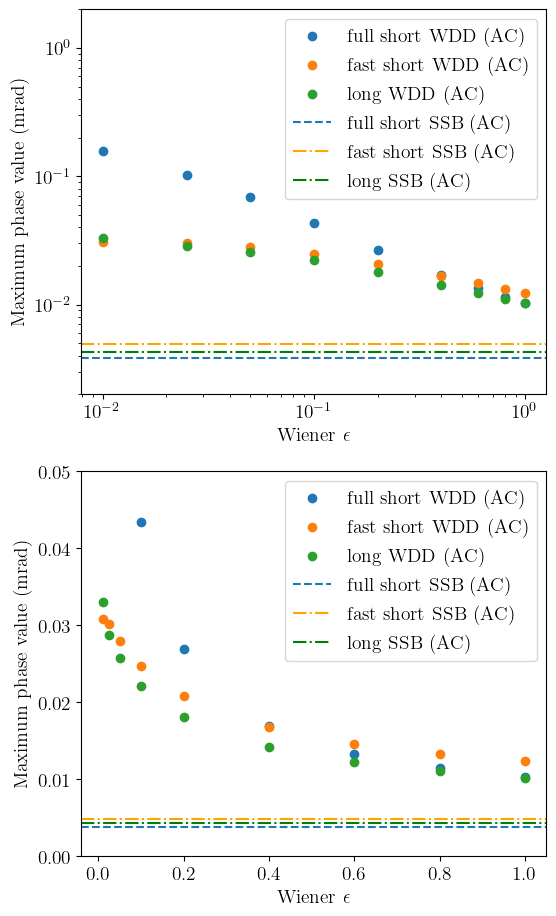

In [649]:
plt.rcParams.update({'text.usetex':True, 'font.family':'stixsans', 'font.size':14, 'mathtext.fontset':'dejavusans'})
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(6,11))

ax1.scatter(datafull['epsilons'], datafull['wddmaxvals_ac'], label=r"full short WDD (AC)")
ax1.scatter(datafast['epsilons'], datafast['wddmaxvals_ac'], label=r"fast short WDD (AC)")
ax1.scatter(datalong['epsilons'], datalong['wddmaxvals_ac'], label=r"long WDD (AC)")
ax1.axhline(float(datafull['ssbmaxval_ac']), linestyle='--', label=r"full short SSB (AC)")
ax1.axhline(float(datafast['ssbmaxval_ac']), linestyle='-.', label=r"fast short SSB (AC)", color='orange')
ax1.axhline(float(datalong['ssbmaxval_ac']), linestyle='-.', label=r"long SSB (AC)", color='green',)
ax1.set_ylabel("Maximum phase value (mrad)")
ax1.set_xlabel(r"Wiener $\epsilon$")
ax1.legend()
ax1.set_ylim((0,0.05))

ax2.scatter(datafull['epsilons'], datafull['wddmaxvals_ac'], label=r"full short WDD (AC)")
ax2.scatter(datafast['epsilons'], datafast['wddmaxvals_ac'], label=r"fast short WDD (AC)")
ax2.scatter(datalong['epsilons'], datalong['wddmaxvals_ac'], label=r"long WDD (AC)")
ax2.axhline(float(datafull['ssbmaxval_ac']), linestyle='--', label=r"full short SSB (AC)")
ax2.axhline(float(datafast['ssbmaxval_ac']), linestyle='-.', label=r"fast short SSB (AC)", color='orange')
ax2.axhline(float(datalong['ssbmaxval_ac']), linestyle='-.', label=r"long SSB (AC)", color='green',)
ax2.set_ylabel("Maximum phase value (mrad)")
ax2.set_xlabel(r"Wiener $\epsilon$")
ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim((2e-3,2))
            
plt.savefig(dire + "results/analyses/" + name + "_wdd_epsilonvariation_loglog.pdf")
plt.show()

### Make all plots

In [ ]:
show_intermediate_outputs = False
plot_output = True
savefig = False

#### 36 mrad

In [ ]:
# For different binnings of the diffraction patterns (binQ).

dt = 33.4
ang = 36
binQ = 2
thinR = 1
rpix = 512
qpix = 192

for binQ in [16, 8, 4, 2, 1]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "figures/" + name
    
    me, res, times = loadresults(dire, name)
    plotresults(me, res, path, savefig=savefig)

In [ ]:
# For different thinnings of the real-space scan grid (thinR).

dt = 33.4
ang = 36
binQ = 2
rpix = 512
qpix = 192
thinR = 1

for thinR in [8, 4, 2, 1]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "figures/" + name

    me, res, times = loadresults(dire, name)
    plotresults(me, res, path, savefig=savefig)

In [ ]:
# Maximum frame rate of the ARINA (using 2x hardware binning in Q).

dt = 10.0
ang = 36
thinR = 1
rpix = 512
qpix = 96

for binQ in [4, 2, 1]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "figures/" + name

    me, res, times = loadresults(dire, name)
    plotresults(me, res, path, savefig=savefig)

#### 60 mrad

In [ ]:
dt = 33.4
ang = 60
thinR = 1
rpix = 512
qpix = 192

for binQ in [16, 8, 4, 2, 1]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "figures/" + name

    me, res, times = loadresults(dire, name)
    plotresults(me, res, path, savefig=savefig)

#### 109 mrad

In [ ]:
dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

for binQ in [8, 4, 2, 1]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "figures/" + name

    me, res, times = loadresults(dire, name)
    plotresults(me, res, path, savefig=savefig)

## Phase optimization

In [572]:
# Iterative kernel optimization to fit atomic phases in an image based on a given atomic model.
# Uses the "STEM Optimization" code by Christoph Hofer: https://gitlab.com/christoph_hofer/stem_optimization
# Method described in DOI: 10.1016/j.ultramic.2023.113829

import os,sys
sys.path.append('/Users/tomasusi/git/stem_optimization')
from Model import Model
from Simulation import Simulation

import ase
from ase.io import read, write
import matplotlib.pyplot as plt
import numpy as np
import threading
import pickle
from ase.visualize import view
from abtem import orthogonalize_cell
from ase import Atoms
from ase.lattice.hexagonal import Graphene

# Bins the phase images in R to reduce processing time.
def rebin(arr, binfactor):
    binned = arr.copy()
    new_shape = tuple(np.dot(binned.shape, 1/binfactor).astype("int"))
    shape = (new_shape[0], binned.shape[0] // new_shape[0],
             new_shape[1], binned.shape[1] // new_shape[1])
    return binned.reshape(shape).mean(-1).mean(1)

# Takes a numpy file with saved phase images and returns a list with the corresponding images.
def make_images(res, transpose=False):
    
    ssbimage = res['ssb_phase']
    ssbacimage = res['ssb_phase_ac']
    wddimage = np.fliplr(res['wdd_phase'])
    wddacimage = np.fliplr(res['wdd_phase_ac'])
    
    dpcimage = res['dpc']
    parimage = res['parallax']
    ptyimage = res['ptycho']

    if transpose:
        return([ssbimage.T, ssbacimage.T, wddimage.T, wddacimage.T, dpcimage.T, parimage.T, ptyimage.T])
    else:
        return([ssbimage, ssbacimage, wddimage, wddacimage, dpcimage, parimage, ptyimage])

# Optimizes a single model to reproduce a single phase image contrast.
# Bins the images in R additionally to speed up optimization.
def optimize_model(arr, binfactor, atoms, progress_bar=False, plot=False):

    conv_angle = 0.034 #rad
    energy = 60000 #eV
    
    fov = np.min([atoms.cell[0,0], atoms.cell[1,1]])/10# 

    image = rebin(arr, binfactor)
    px = np.min(image.shape)
    
    m = Model(atoms, image, kernelsize=1, plot=plot)
    m.set_up_simulation(conv_angle, energy, fov, blur=blur, method='SSB')

    rounds1 = 40
    m.optimize_model(['fov','blur','translation','scale'],
                     iterations = rounds1, progress_bar=True)

    rounds2 = 40
    m.optimize_model(['fov','blur','translation','scale','positions'],
                     iterations = rounds2, progress_bar=True)

    rounds3 = 60
    m.optimize_model(['fov','blur','translation','scale','positions','intensities'], 
                     iterations = rounds3, progress_bar=True)
    #m.normalize_intensities()
    return m

# Runs optimizations in batch for all the phase images from different reconstructions.
# Bins the images in R additionally to speed up optimization.
def batch_optimize(images, binfactor, atoms):
        
    models = []
    i = 1
    for im in images[:-1]:
        try:
            models.append(optimize_model(im, binfactor, atoms))
        except:
            print("Failed for model " +str(i))
                  
        i += 1
    try:
        models.append(optimize_model(images[-1], 1, atoms))
    except:
        print("Failed for model " +str(i))
    
    return(models)

# Batch optimization run in parallel using Python multiprocessing
# (required .py file to be saved and loaded as module from disk).
# Bins the images in R additionally to speed up optimization.
def batch_optimize_parallel(images, binfactor, atoms):

    from batch_optimize import optimize_model_parallel    
    from multiprocessing import Pool
        
    models = []

    args = [(rebin(im, binfactor), atoms) for im in images[:-1]]
    args.append((images[-1], atoms)) # Do not bin GD images

    with Pool(7) as p:
        models = p.map(optimize_model_parallel, args)

    return(models)

# Plots the fitting error of the iterative phase optimization algorithm.
def plot_errors(models, name):
    
    plt.plot(models[0].error_rounds, label="SSB")
    plt.plot(models[1].error_rounds, label="SSB AC")
    plt.plot(models[2].error_rounds, label="WDD")
    plt.plot(models[3].error_rounds, label="WDD AC")
    plt.plot(models[4].error_rounds, label="DPC")
    plt.plot(models[5].error_rounds, label="Parallax")
    plt.plot(models[6].error_rounds, label="Iterative GD")
    #plt.xlim((10,30))
    #plt.yscale('log')
    plt.ylim((0.7,1.0))
    plt.ylabel('Correlation')
    plt.xlabel('Rounds')
    plt.legend()#
    plt.savefig('results/analyses/' + name + "_optimization.pdf")
    #plt.show()
    plt.close()
    
    #return fig

# Makes a histogram of atomic phase variation, calculates mean and standard error of the mean.
def make_histo(m, selected_atoms, relative=True):
    m.normalize_intensities()
    intensities = m.intensities[selected_atoms]
    if relative == True:
        intensities /= intensities.mean()
    counts, bins = np.histogram(intensities)
    
    mids = 0.5*(bins[1:] + bins[:-1])

    mean = np.average(mids, weights=counts)
    var = np.average((mids - mean)**2, weights=counts)
    err = np.sqrt(var) #/np.sum(countsssb)

    return(counts, bins, mean, err)

# Plots the histograms for all models, saves mean phase values and their variation for each model to disk.
# The try-except statements allow plotting to complete even if some data is missing.
def plot_histo(models, atoms, relative=False, name = 'noname', label = '', factor = 1):
    
    p = 0.15
    selected_atoms = ((atoms.positions[:,0]>atoms.cell[0,0]*p)*(atoms.positions[:,0]<atoms.cell[0,0]*(1-p))*
                      (atoms.positions[:,1]>atoms.cell[1,1]*p)*(atoms.positions[:,1]<atoms.cell[1,1]*(1-p)))
    try:
        countsssb, binsssb, meanssb, errssb = make_histo(models[0], selected_atoms, relative=relative)
    except:
        print("Failed for model SSB.")
    try:
        countsssbac, binsssbac, meanssbac, errssbac = make_histo(models[1], selected_atoms, relative=relative)
    except:
        print("Failed for model SSB_AC.")
    try:
        countswdd, binswdd, meanwdd, errwdd = make_histo(models[2], selected_atoms, relative=relative)
    except:
        print("Failed for model WDD.")
    try:
        countswddac, binswddac, meanwddac, errwddac = make_histo(models[3], selected_atoms, relative=relative)
    except:
        print("Failed for model WDD_AC.")
    try:
        countsdpc, binsdpc, meandpc, errdpc = make_histo(models[4], selected_atoms, relative=relative)
    except:
        print("Failed for model DPC.") 
    try:
        countspar, binspar, meanpar, errpar = make_histo(models[5], selected_atoms, relative=relative)
    except:
        print("Failed for model parallax.")
    try:
        countspty, binspty, meanpty, errpty = make_histo(models[6], selected_atoms, relative=relative)
    except:
        print("Failed for model GD.")
    
    if relative:
        try:
            plt.stairs(countsssb, binsssb, label = "SSB")
        except:
            print("Failed plot for model SSB.")
        try:
            plt.stairs(countsssbac, binsssbac, label = "SSB AC")
        except:
            print("Failed plot for model SSB_AC.")
        try:
            plt.stairs(countswdd, binswdd, label = "WDD")
        except:
            print("Failed plot for model WDD.")
        try:
            plt.stairs(countswddac, binswddac, label = "WDD AC")
        except:
            print("Failed plot for model WDD_AC.")
        try:
            plt.stairs(countsdpc, binsdpc, label = "DPC")
        except:
            print("Failed plot for model DPC.") 
        try:
            plt.stairs(countspar, binspar, label = "Parallax")
        except:
            print("Failed plot for model parallax.")
        try:
            plt.stairs(countspty, binspty, label = "Iterative GD")
        except:
            print("Failed plot for model GD.")
            
        plt.legend()
        plt.title("Relative phase variation over graphene C atoms" + " " + str(label))
        plt.ylabel("Bin population")
        plt.xlabel("Relative phase")
        #plt.show()
        plt.savefig("results/analyses/" + name + "_relphase.pdf", dpi=600)
        plt.close()
    
    if relative==False:
        
        try:
            np.savetxt("results/analyses/" + name + "_phases.txt",
                       np.dot([meanssb, errssb, meanssbac, errssbac, meanwdd, errwdd, meanwddac, errwddac,
                        meandpc, errdpc, meanpar, errpar, meanpty, errpty], 1000),
                      header = 'Mean and std error in mrad',)
        except:
            print("Could not save phases.")
        
        try:
            plt.stairs(countsssb, 1000*binsssb / factor, label = "SSB")
        except:
            print("Failed plot for model SSB.")
        try:
            plt.stairs(countsssbac, 1000*binsssbac / factor, label = "SSB AC")
        except:
            print("Failed plot for model SSB_AC.")
        try:
            plt.stairs(countswdd, 1000*binswdd / factor, label = "WDD")
        except:
            print("Failed plot for model WDD.")
        try:
            plt.stairs(countswddac, 1000*binswddac / factor, label = "WDD AC")
        except:
            print("Failed plot for model WDD_AC.")
        try:
            plt.stairs(countsdpc, 1000*binsdpc / factor, label = "DPC")
        except:
            print("Failed plot for model DPC.") 
        try:
            plt.stairs(countspar, 1000*binspar / factor, label = "Parallax")
        except:
            print("Failed plot for model parallax.")
        try:
            plt.stairs(countspty, 1000*binspty / factor, label = "Iterative GD")
        except:
            print("Failed plot for model GD.")

        plt.legend(loc=1, bbox_to_anchor=(0.75, 1.0))
        plt.title("Phase variation over graphene C atoms" + " " + str(label))
        plt.ylabel("Bin population")
        plt.xlabel("Phase magnitude (mrad)")
        plt.xlim((-1, 20))
        #plt.show()
        plt.savefig("results/analyses/" + name + "_absphase.pdf", dpi=600)
        plt.close()

In [603]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

# Visualize one image and the corresponding model as an example.

dt = 33.4
ang = 36
binQ = 2
thinR = 1
rpix = 512
qpix = 192

name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
path = dire + "results/" + name

res = np.load(path + ".npz")
    
original = res['parallax'].copy()

from abtem.visualize import show_atoms

# Lattice constant and perpendicular cell size.
lc = 2.46
vac = 12.0

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))
structure.pbc = True

if ang == 109:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((0.8,1.4,0))
    atoms.wrap()
    if ang == 109 and binQ > 1:
        atoms.translate((0.8,1.4,0))
        atoms.wrap()
        #del atoms[[atom.index for atom in atoms if atom.position[0] > 21]]

if ang == 60:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((-0.3,0.3,0))
    atoms.wrap()
    del atoms[[atom.index for atom in atoms if atom.position[0] > 21]]
    del atoms[[atom.index for atom in atoms if atom.position[1] < 1]]
    cell = atoms.cell
    atoms.set_cell(cell*0.98)
    atoms.center()
    atoms.translate((0.1,0.3,0))
    
if ang == 36:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((0.5,0.3,0))
    atoms.wrap()
    atoms.set_cell(atoms.cell/1.02, scale_atoms=False)

if ang == 36 and dt == 10.0:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((0.5,0.9,0))
    atoms.wrap()

p = 0.15
selected_atoms = ((atoms.positions[:,0]>atoms.cell[0,0]*p)*(atoms.positions[:,0]<atoms.cell[0,0]*(1-p))*
                  (atoms.positions[:,1]>atoms.cell[1,1]*p)*(atoms.positions[:,1]<atoms.cell[1,1]*(1-p)))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))
ax1.imshow(original, origin='lower', extent=(0,21,0,21))
ax1.set_xlabel("x [Å]")
ax1.set_ylabel("y [Å]")
show_atoms(atoms,ax=ax2);
#plt.savefig(dire + "results/figures/" + name + "_imagevsmodel_ssb.pdf", dpi=300)

In [604]:
model = optimize_model(original, 4, atoms, progress_bar=True, plot=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:38<00:00,  9.95s/it]


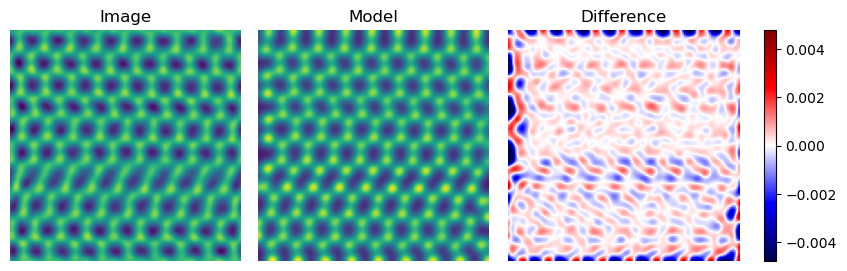

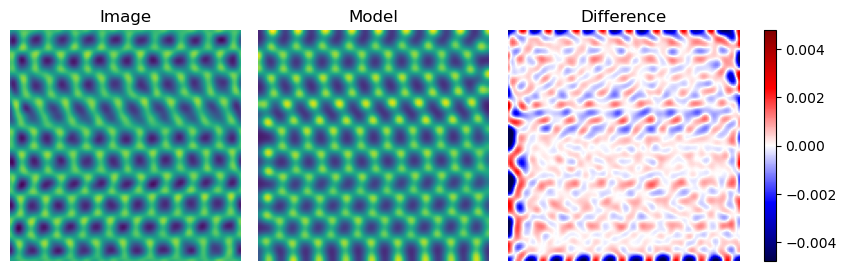

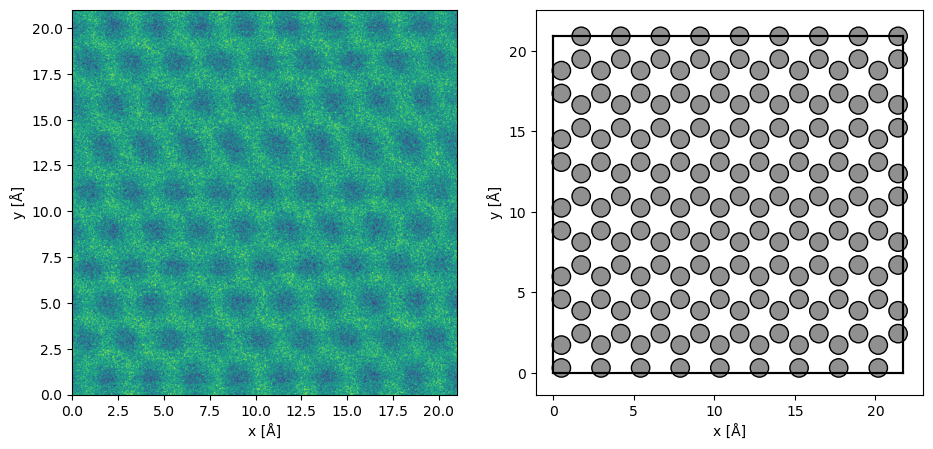

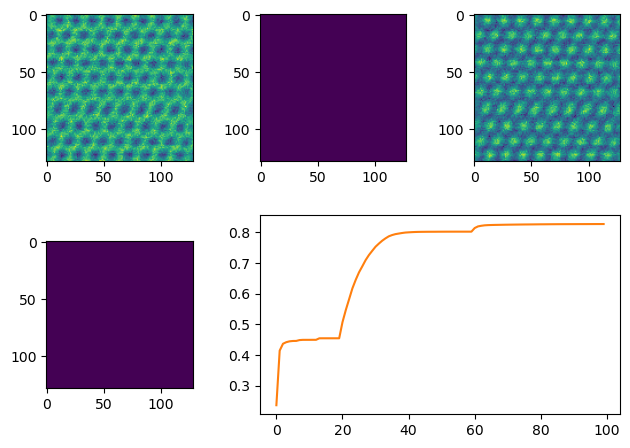

In [605]:
plt.plot(model.error_rounds)
plt.show()

In [606]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,3),
                                  gridspec_kw={'wspace':-0.6,'width_ratios': [1,1,0.875]})
#im1 = ax1.imshow(model.image, vmax=-model.image.min())
#im2 = ax2.imshow(model.simulation, vmax=-model.image.min(), vmin=model.image.min())
#im3 = ax3.imshow(model.diffimage, vmax=-model.image.min(), vmin=model.image.min(), cmap = 'seismic')

im1 = ax1.imshow(np.flipud(model.image), vmax=-model.image.min())
im2 = ax2.imshow(np.flipud(model.simulation), vmax=-model.image.min(), vmin=model.image.min())
im3 = ax3.imshow(np.flipud(model.diffimage), vmax=-model.image.min(), vmin=model.image.min(), cmap = 'seismic')

#fig.colorbar(im1, ax=ax1)
#fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
ax1.axis('off')
ax1.set_title('Image')
ax2.axis('off')
ax2.set_title('Model')
ax3.axis('off')
ax3.set_title('Difference')
plt.savefig(dire + "results/figures/" + name + "_optresult_parallax.pdf", dpi=300)

### Process in batches

In [42]:
conv_angle = 0.034 #rad
energy = 60000 #eV
blur = 0

# Lattice constant and perpendicular cell size.
lc = 2.46
vac = 12.0

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))
structure.pbc = True

In [ ]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.9,0.2,0))
atoms.wrap()
    
try:
    dt = 33.4
    ang = 36
    thinR = 1
    rpix = 512
    qpix = 192

    for binQ in [16, 8, 4, 2, 1]: 

        name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
        path = dire + name

        res = np.load(path + ".npz")

        images = make_images(res)

        modelsexp = batch_optimize_parallel(images, 4, atoms)
        
        names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]
        
        for i in range(7):
            write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
            
            np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(), allow_pickle=True)

        plot_errors(modelsexp, name)
                
        plot_histo(modelsexp, atoms, False, name, label='(exp)')
        plot_histo(modelsexp, atoms, True, name, label='(exp)')
except:
    print("Moving on.")

In [ ]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.5,1.2,0))
atoms.wrap()

dt = 10.0
ang = 36
thinR = 1
rpix = 512
qpix = 96

try:
    for binQ in [4,2,1]:
        name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
        path = dire + name
    
        res = np.load(path + ".npz")
    
        images = make_images(res)
    
        modelsexp = batch_optimize_parallel(images, 4, atoms)
        
        names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]
        
        for i in range(7):
            write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
            
            np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)
    
        plot_errors(modelsexp, name)
                
        plot_histo(modelsexp, atoms, False, name, label='(exp)')
        plot_histo(modelsexp, atoms, True, name, label='(exp)')

except:
    print("Moving on.")

In [ ]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((-0.3,0.3,0))
atoms.wrap()
del atoms[[atom.index for atom in atoms if atom.position[0] > 21]]
del atoms[[atom.index for atom in atoms if atom.position[1] < 1]]
cell = atoms.cell
atoms.set_cell(cell*0.98)
atoms.center()
atoms.translate((0.1,0.3,0))

try:
    dt = 33.4
    ang = 60
    thinR = 1
    rpix = 512
    qpix = 192

    for binQ in [16, 8, 4, 2, 1]:

        name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
        path = dire + name

        res = np.load(path + ".npz")

        images = make_images(res)
    
        modelsexp = batch_optimize_parallel(images, 4, atoms)
        
        names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]
        
        for i in range(7):
            write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
            
            np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)

        plot_errors(modelsexp, name)
                
        plot_histo(modelsexp, atoms, False, name, label='(exp)')
        plot_histo(modelsexp, atoms, True, name, label='(exp)')
except:
    print("Moving on.")

In [ ]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.2,0.2,0))
atoms.wrap()
    
try:
    dt = 33.4
    ang = 36
    binQ = 2
    rpix = 512
    qpix = 192

    for thinR in [8, 4, 2]:

        try:
            name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
            path = dire + name

            res = np.load(path + ".npz")

            images = make_images(res)
    
            modelsexp = batch_optimize_parallel(images, 4, atoms)

            names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]

            for i in range(7):
                try:
                    write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
                    np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)
                except:
                    print("No model found.")
                    
            plot_errors(modelsexp, name)

            plot_histo(modelsexp, atoms, False, name, label='(exp)')
            plot_histo(modelsexp, atoms, True, name, label='(exp)')
        except:
            print("Failed for thinning " + str(thinR))
except:
    print("Moving on.")

In [ ]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((-0.3,0.3,0))
atoms.wrap()
del atoms[[atom.index for atom in atoms if atom.position[0] > 21]]
del atoms[[atom.index for atom in atoms if atom.position[1] < 1]]
cell = atoms.cell
atoms.set_cell(cell*0.98)
atoms.center()
atoms.translate((0.1,0.3,0))
    
try:
    dt = 33.4
    ang = 60
    thinR = 1
    rpix = 512
    qpix = 192

    for binQ in [4, 2, 1]: 

        try:
            name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
            path = dire + name

            res = np.load(path + ".npz")

            images = make_images(res)
    
            modelsexp = batch_optimize_parallel(images, 4, atoms)

            names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]

            for i in range(7):
                try:
                    write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
                    np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)
                except:
                    print("No model found.")
                    
            plot_errors(modelsexp, name)

            plot_histo(modelsexp, atoms, False, name, label='(exp)')
            plot_histo(modelsexp, atoms, True, name, label='(exp)')
        except:
            print("Failed for binning " + str(binQ))
except:
    print("Moving on.")

In [65]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.8,1.4,0))
atoms.wrap()
    
try:
    dt = 100
    ang = 109
    thinR = 1
    rpix = 256
    qpix = 192

    for binQ in [8, 4, 2, 1]: 
        try:
            name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
            path = dire + name

            res = np.load(path + ".npz")
            
            images = make_images(res)
        
            modelsexp = batch_optimize_parallel(images, 4, atoms)
            
            names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "dpc", "par", "pty"]
            
            for i in range(7):
                write('results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
                
                np.save('results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)
    
            plot_errors(modelsexp, name)
            
            plot_histo(modelsexp, atoms, False, name, label='(exp)')
            plot_histo(modelsexp, atoms, True, name, label='(exp)')
        except:
            print("Failed for binning " + str(binQ))
except:
    print("Moving on.")

100%|██████████| 80/80 [10:34<00:00,  7.93s/it]


## Analyze fitted phases

In [122]:
names = ["SSB", "SSB (AC)", "WDD", "WDD (AC)", "DPC", "Parallax", "Iter. GD"]
plt.rcParams['text.usetex'] = False

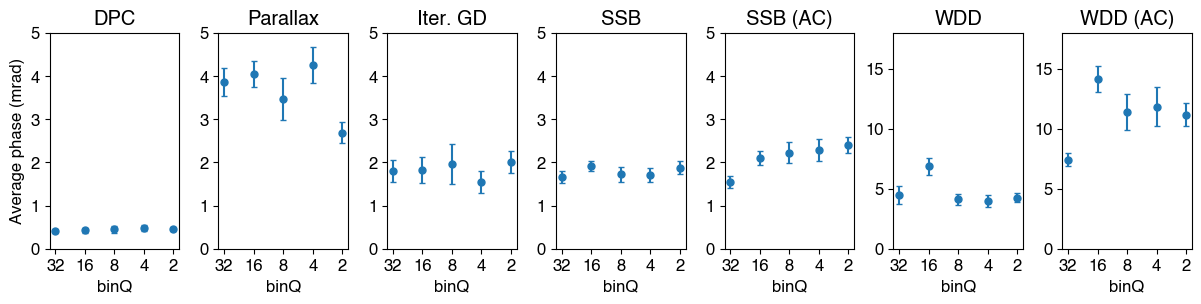

In [229]:
dt = 33.4
ang = 36
thinR = 1
rpix = 512
qpix = 192

binQ = [32, 16, 8, 4, 2]

bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i])
    path = dire + "analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.3, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Average phase (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("binQ")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("binQ")  

axs[0].set_ylim((0,5))
axs[1].set_ylim((0,5))
axs[2].set_ylim((0,5))
axs[3].set_ylim((0,5))
axs[4].set_ylim((0,5))
axs[5].set_ylim((0,18))
axs[6].set_ylim((0,18))

plt.savefig(dire + "analyses/res" + str(ang) + "mrad_full_binQ_phaseplots.pdf")

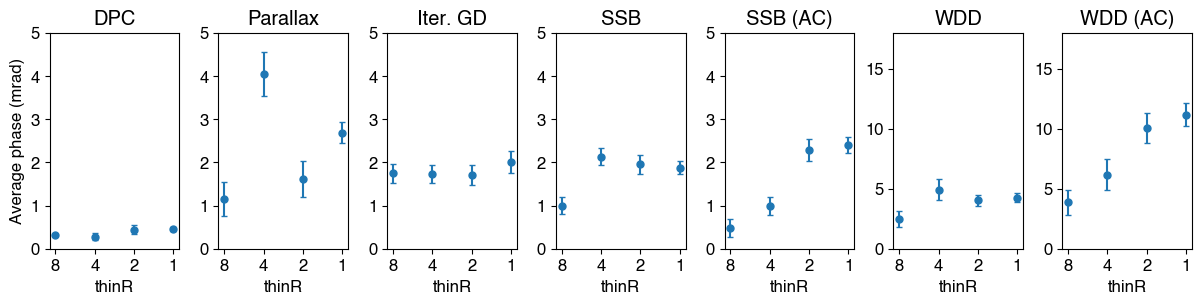

In [225]:
dt = 33.4
ang = 36
binQ = 2
thinR = 1
rpix = 512
qpix = 192

thinR = [8, 4, 2, 1]

tRs = []
for tR in thinR:
    tRs.append(str(tR))

means = np.empty((len(thinR),7))
errors = np.empty((len(thinR),7))

for i in range(len(thinR)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR[i]) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.3, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Average phase (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(tRs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("thinR")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(tRs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("thinR")  

axs[0].set_ylim((0,5))
axs[1].set_ylim((0,5))
axs[2].set_ylim((0,5))
axs[3].set_ylim((0,5))
axs[4].set_ylim((0,5))
axs[5].set_ylim((0,18))
axs[6].set_ylim((0,18))

plt.savefig(dire + "analyses/res" + str(ang) + "mrad_full_thinR_phaseplots.pdf")

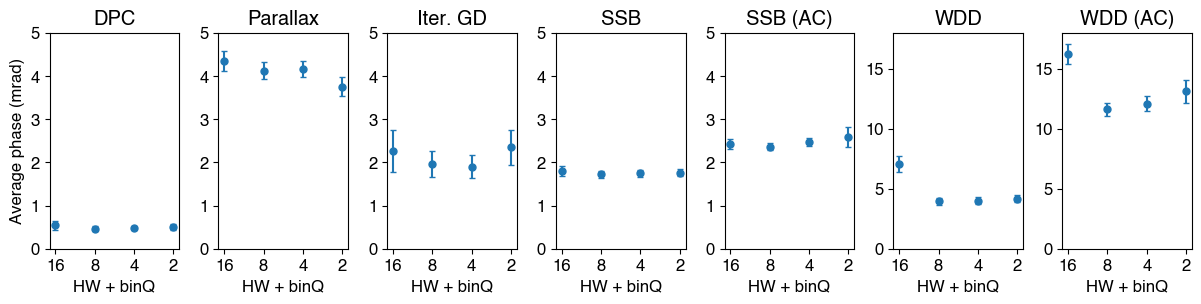

In [231]:
dt = 10.0
ang = 36
binQ = 1
thinR = 1
rpix = 512
qpix = 96

binQ = [32, 16, 8, 4, 2, 1]
bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)-1):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i+1])
    path = dire + "analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.3, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Average phase (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("HW + binQ")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("HW + binQ")  

for ax in axs:
    ax.set_xlim([0.85,4.15])
    
axs[0].set_ylim((0,5))
axs[1].set_ylim((0,5))
axs[2].set_ylim((0,5))
axs[3].set_ylim((0,5))
axs[4].set_ylim((0,5))
axs[5].set_ylim((0,18))
axs[6].set_ylim((0,18))

#fig.suptitle(str(ang) + " mrad " + str(dt) + " us " + str(qpix) + " qpix");
plt.savefig(dire + "analyses/res" + str(ang) + "mrad_fast_binQ_phaseplots.pdf")

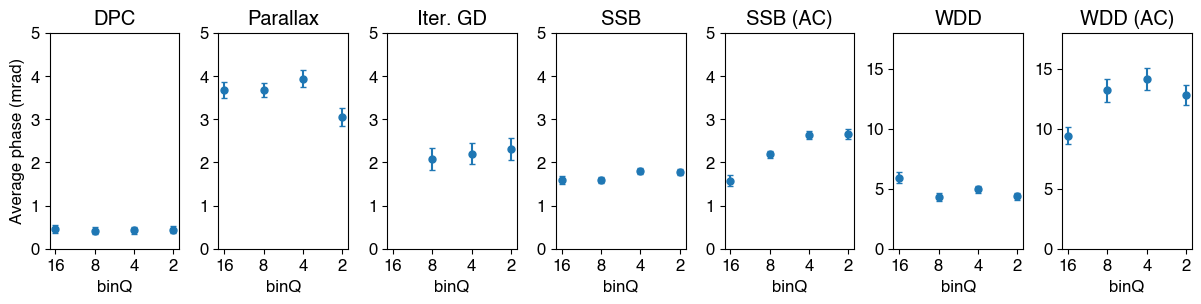

In [234]:
dt = 33.4
ang = 60
thinR = 1
rpix = 512
qpix = 192

binQ = [16, 8, 4, 2]
bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i])
    path = dire + "analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.3, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Average phase (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("binQ")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("binQ")  

axs[0].set_ylim((0,5))
axs[1].set_ylim((0,5))
axs[2].set_ylim((0,5))
axs[3].set_ylim((0,5))
axs[4].set_ylim((0,5))
axs[5].set_ylim((0,18))
axs[6].set_ylim((0,18))

#fig.suptitle(str(ang) + " mrad " + str(dt) + " us " + str(qpix) + " qpix");
plt.savefig(dire + "analyses/res" + str(ang) + "mrad_binQ_phaseplots.pdf")

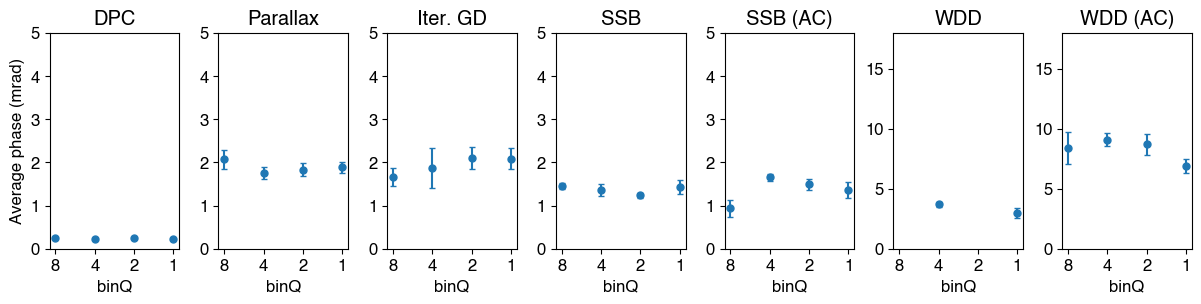

In [233]:
dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

binQ = [8, 4, 2, 1]

bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i])
    path = dire + "analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.3, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Average phase (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("binQ")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("binQ")  

axs[0].set_ylim((0,5))
axs[1].set_ylim((0,5))
axs[2].set_ylim((0,5))
axs[3].set_ylim((0,5))
axs[4].set_ylim((0,5))
axs[5].set_ylim((0,18))
axs[6].set_ylim((0,18))

#fig.suptitle(str(ang) + " mrad " + str(dt) + " us " + str(qpix) + " qpix");
plt.savefig(dire + "analyses/res" + str(ang) + "mrad_long_binQ_phaseplots.pdf")